In [1]:
import os
import stan_jupyter as stan
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import multiprocessing
import pickle
import arviz as az

In [2]:
# %load_ext jupyterstan

In [3]:
%load_ext stanmagic

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set() 

In [6]:
# try:
#     multiprocessing.set_start_method("fork") # For multiprocessing in stan
# except RuntimeError:
#     pass

# Item + User

In [45]:
# Seed
np.random.seed(1234)


sg_u = .1 * np.eye(2)
sg_w = .2 * np.eye(2)

sg_theta = .07 * np.eye(2)

# Number of users
n_u = 11
# Number of words
n_w = 16

# Generate data
U = np.random.multivariate_normal(np.zeros(2), sg_u, size=n_u)   # User ability
W = np.random.multivariate_normal(np.zeros(2), sg_w, size=n_w)   # Item difficulty

theta = np.random.multivariate_normal(np.zeros(2), sg_theta, size=(n_w, n_u))

for w in range(n_w):
    for u in range(n_u):
        theta[w,u] = theta[w,u] + U[u] + W[w]
        
data = {'n_u': n_u, 'n_w': n_w, 'theta': theta}

In [46]:
%%stan -v model
data {
    int<lower=0> n_u;  // Number of users    
    int<lower=0> n_w;  // Number of words
    vector[2] theta[n_w, n_u];
}
parameters {
  
    cov_matrix[2] sg_u;
    cov_matrix[2] sg_w;
    
    cov_matrix[2] sg_theta;
    
    vector[2] W[n_w];
    vector[2] U[n_u];
}
model {
    U[1:n_u] ~ multi_normal(rep_vector(0, 2), sg_u);
    W[1:n_w] ~ multi_normal(rep_vector(0, 2), sg_w);
    
    for (u in 1:n_u) {
        for (w in 1:n_w) {
            theta[w,u] ~ multi_normal(U[u] + W[w], sg_theta);
        }
    }
}

Using stanc compiler:  /Users/aureliennioche/cmdstan-2.26.1/bin/stanc
/Users/aureliennioche/cmdstan-2.26.1/bin/stanc --o=/var/folders/yg/spp3n_c56vxbgvjy9wthwy_h0000gn/T/anon_382f1d9a-b236-4a55-856b-23c370c4f6de_model.cpp /var/folders/yg/spp3n_c56vxbgvjy9wthwy_h0000gn/T/anon_382f1d9a-b236-4a55-856b-23c370c4f6de.stan

-------------------------------------------------------------------------------
Model compiled successfully. Output stored in model object.
Type model in a cell to see a nicely formatted code output in a notebook
     ^^^^^
Access model compile output properties
model.model_file -> Name of stan_file [None]
model.model_name -> Name of stan model [None]
model.model_code -> Model code [data {     int<lower ....]


In [47]:
# model

In [48]:
post = stan.build(model.model_code, data=data, random_seed=1234)

Building... Found model in cache.
Warnings from stanc:
  The parameter sg_theta has no priors.
  The parameter sg_u has no priors.
  The parameter sg_w has no priors.


In [49]:
# Train the model and generate samples
fit = post.sample(num_chains=4, num_samples=1000)


Messages received during sampling:
  Gradient evaluation took 0.000433 seconds
  1000 transitions using 10 leapfrog steps per transition would take 4.33 seconds.
  Adjust your expectations accordingly!
error:Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
error:Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = inf, but Covariance matrix[2,1] = inf (in '/var/folders/yg/spp3n_c56vxbgvjy9wthwy_h0000gn/T/httpstan_eoqjr44c/model_gp4vkk3d.stan', line 22, column 12 to column 61)
error:If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
error:but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
error:
error:Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
error:Exception: multi_normal_lpdf: Covari

error:Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
error:Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = inf, but Covariance matrix[2,1] = inf (in '/var/folders/yg/spp3n_c56vxbgvjy9wthwy_h0000gn/T/httpstan_eoqjr44c/model_gp4vkk3d.stan', line 17, column 4 to column 52)
error:If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
error:but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
error:
error:Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
error:Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is nan. (in '/var/folders/yg/spp3n_c56vxbgvjy9wthwy_h0000gn/T/httpstan_eoqjr44c/model_gp4vkk3d.stan', line 17, column 4 t

In [50]:
fit.to_frame()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,sg_u.1.1,sg_u.2.1,sg_u.1.2,...,U.2.2,U.3.2,U.4.2,U.5.2,U.6.2,U.7.2,U.8.2,U.9.2,U.10.2,U.11.2
draws,,,,,,,,,,,,,,,,,,,,,
0,320.898901,0.876288,0.248902,4.0,15.0,0.0,-287.021376,0.190039,-0.203250,-0.203250,...,-0.117424,0.242892,-0.003637,-0.696791,0.375754,-0.574285,-0.020586,0.058782,-0.478066,-0.145499
1,304.225866,0.801790,0.224775,4.0,15.0,0.0,-266.629113,0.239510,-0.068689,-0.068689,...,-0.244984,0.250314,-0.227928,-0.743538,0.248835,-0.818342,-0.074059,0.103512,-0.742941,-0.135564
2,313.858060,0.864062,0.292558,3.0,7.0,0.0,-275.205118,0.104092,-0.046318,-0.046318,...,0.013743,0.396025,0.112880,-0.553087,0.461993,-0.528550,0.252157,0.260147,-0.369986,-0.114053
3,311.016613,0.986270,0.227997,4.0,15.0,0.0,-285.267341,0.315946,-0.181022,-0.181022,...,-0.031771,0.435818,0.106582,-0.397096,0.433323,-0.518069,0.203541,0.214623,-0.293651,0.006467
4,322.926886,0.966066,0.248902,4.0,15.0,0.0,-297.681138,0.104585,-0.065636,-0.065636,...,-0.075289,0.310107,-0.219622,-0.709314,0.270003,-0.764759,0.178216,0.118589,-0.545473,-0.280478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,305.386548,0.799090,0.227997,3.0,7.0,0.0,-278.462628,0.366167,-0.208568,-0.208568,...,-0.114063,0.418445,-0.091118,-0.755686,0.309047,-0.636399,-0.010773,0.178631,-0.527136,-0.091396
3996,315.808718,0.937564,0.248902,3.0,7.0,0.0,-293.579975,0.088202,-0.098099,-0.098099,...,-0.111940,0.357369,-0.121366,-0.560596,0.318324,-0.665115,0.140051,0.142562,-0.528957,-0.237010
3997,311.885641,0.967044,0.224775,4.0,15.0,0.0,-266.377827,0.260412,-0.078387,-0.078387,...,-0.058351,0.307985,-0.012157,-0.671611,0.356116,-0.605193,0.217170,0.252890,-0.396067,-0.207297


In [51]:
fit.dims

([2, 2], [2, 2], [2, 2], [16, 2], [11, 2])

In [52]:
fit

<stan.Fit>
Parameters:
    sg_u: (2, 2)
    sg_w: (2, 2)
    sg_theta: (2, 2)
    W: (16, 2)
    U: (11, 2)
Draws: 4000

In [58]:
for i in range(2):
    for j in range(2):
        print(i, j, fit["sg_u"][i, j].mean())

0 0 0.24433212922030464
0 1 -0.14417822132309874
1 0 -0.14417822132309874
1 1 0.3644161501096173


array([[<AxesSubplot:title={'center':'sg_u'}>,
        <AxesSubplot:title={'center':'sg_u'}>]], dtype=object)

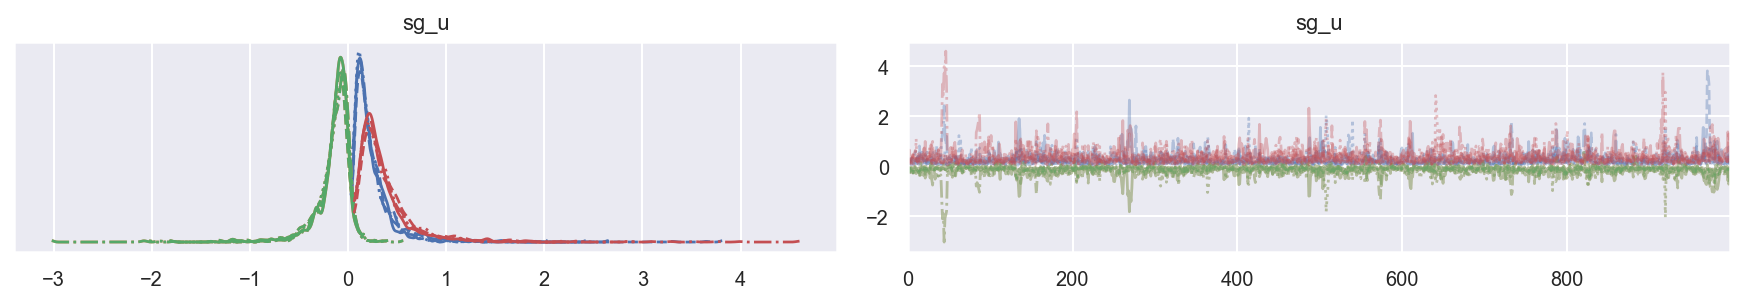

In [54]:
az.plot_trace(fit, var_names="sg_u")

# Simplified

In [10]:
# Seed
np.random.seed(1234)


sg_u = 3
sg_w = 5

sg_theta = 0.5

mu = 6

# Number of users
n_u = 11
# Number of words
n_w = 16
# Number of obs
n_o = 10

# Generate data
U = np.random.normal(0, sg_u, size=n_u)   # User ability
W = np.random.normal(0, sg_w, size=n_w)   # Item difficulty

theta = np.zeros(shape=(n_w, n_u, n_o))

for w in range(n_w):
    for u in range(n_u):
        theta[w,u, :] = np.random.normal(mu + U[u] + W[w], sg_theta, size=n_o)
        
data = {'n_u': n_u, 'n_w': n_w,  'n_o': n_o, 'theta': theta}

In [11]:
%%stan -v model
data {
  int<lower=0> n_u;  // Number of users    
  int<lower=0> n_w;  // Number of words
  int<lower=0> n_o;  // Number of observations
  real theta[n_w, n_u, n_o];
}
parameters {
  real<lower=0> sg_u;
  real<lower=0> sg_w;
  real<lower=0> sg_theta;
  real mu;

  real W[n_w];
  real U[n_u];
}
model {
  sg_w ~ normal(0, 1);
  sg_u ~ normal(0, 1);
  sg_theta ~ normal(0, 1);
  mu ~ normal(0, 1);
  
  U[1:n_u] ~ normal(0, sg_u);
  W[1:n_w] ~ normal(0, sg_w);

  for (u in 1:n_u) {
      for (w in 1:n_w) {
          theta[w,u] ~ normal(mu + U[u] + W[w], sg_theta);
      }
  }
}

Using pystan.stanc compiler..
-------------------------------------------------------------------------------
Model compiled successfully. Output stored in model object.
Type model in a cell to see a nicely formatted code output in a notebook
     ^^^^^
Access model compile output properties
model.model_file -> Name of stan_file [None]
model.model_name -> Name of stan model [None]
model.model_code -> Model code [data {   int<lower=0 ....]


In [12]:
post = stan.build(model.model_code, data=data, random_seed=1234)

Building...INFO:aiohttp.access:127.0.0.1 [23/Feb/2021:11:12:31 +0000] "POST /v1/models/rrudcug2/params HTTP/1.1" 200 747 "-" "Python/3.9 aiohttp/3.7.3"

INFO:httpstan:Found Stan model in cache (`models/rrudcug2`).
INFO:aiohttp.access:127.0.0.1 [23/Feb/2021:11:12:31 +0000] "POST /v1/models HTTP/1.1" 201 234 "-" "Python/3.9 aiohttp/3.7.3"
INFO:aiohttp.access:127.0.0.1 [23/Feb/2021:11:12:31 +0000] "POST /v1/models/rrudcug2/params HTTP/1.1" 200 747 "-" "Python/3.9 aiohttp/3.7.3"
Found model in cache. Done.


FrozenInstanceError: cannot assign to field '_sample'

In [ ]:
fit = post.sample(num_chains=4, num_samples=1000)

array([<AxesSubplot:title={'center':'sg_u'}>,
       <AxesSubplot:title={'center':'sg_w'}>,
       <AxesSubplot:title={'center':'sg_theta'}>], dtype=object)

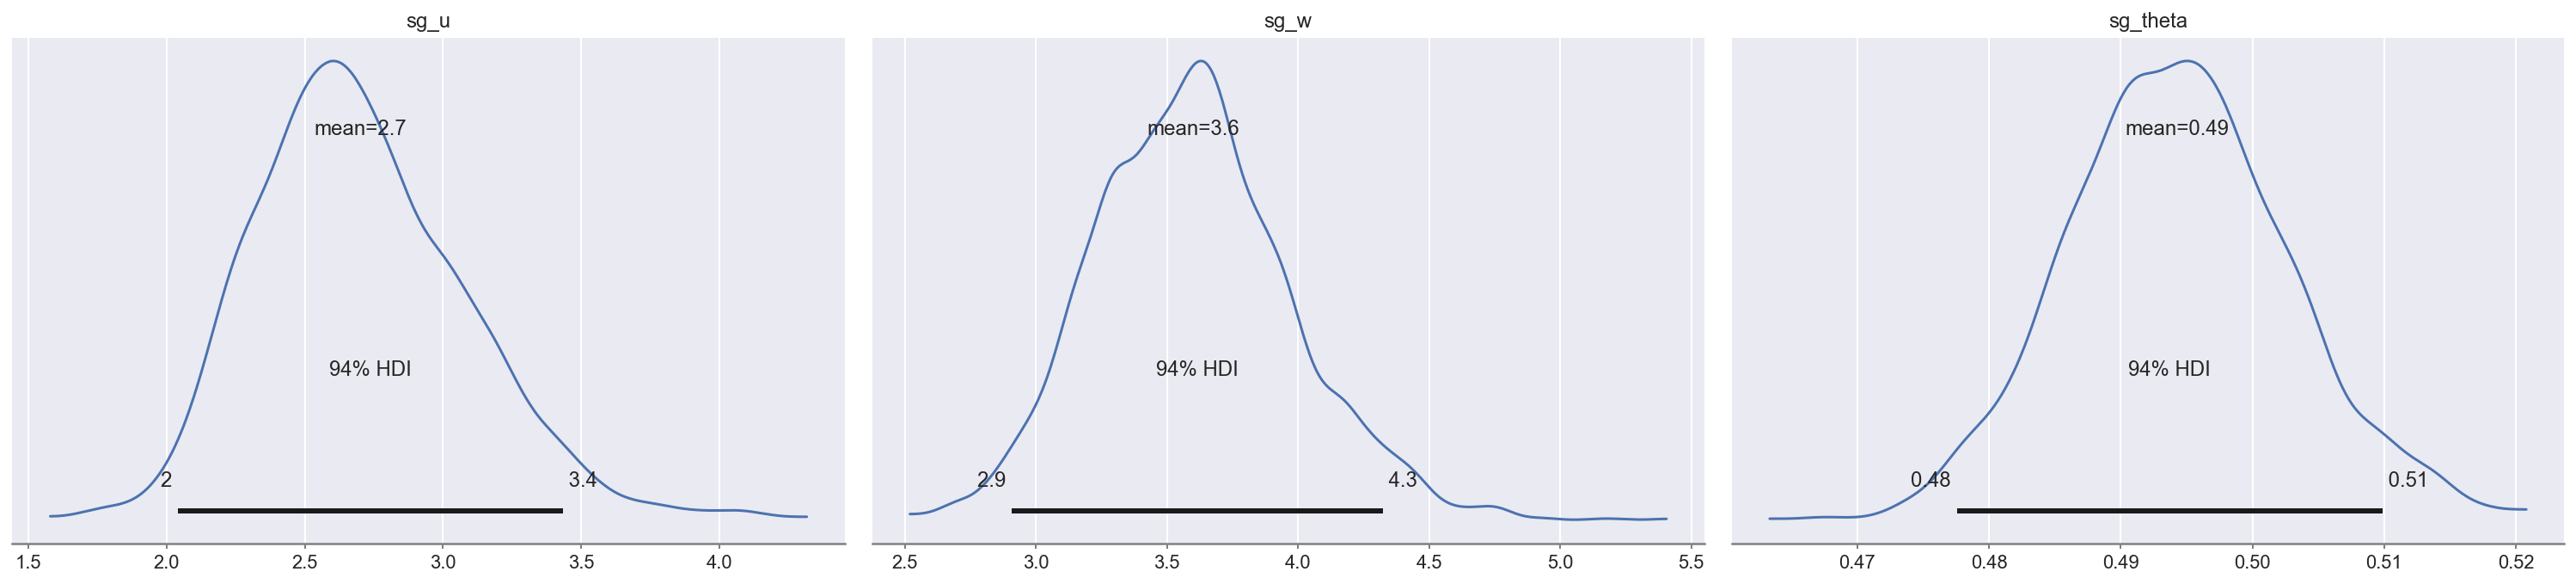

In [32]:
az.plot_posterior(fit, var_names=["sg_u", "sg_w", "sg_theta"])

array([[<AxesSubplot:title={'center':'sg_u'}>,
        <AxesSubplot:title={'center':'sg_u'}>],
       [<AxesSubplot:title={'center':'sg_w'}>,
        <AxesSubplot:title={'center':'sg_w'}>],
       [<AxesSubplot:title={'center':'sg_theta'}>,
        <AxesSubplot:title={'center':'sg_theta'}>]], dtype=object)

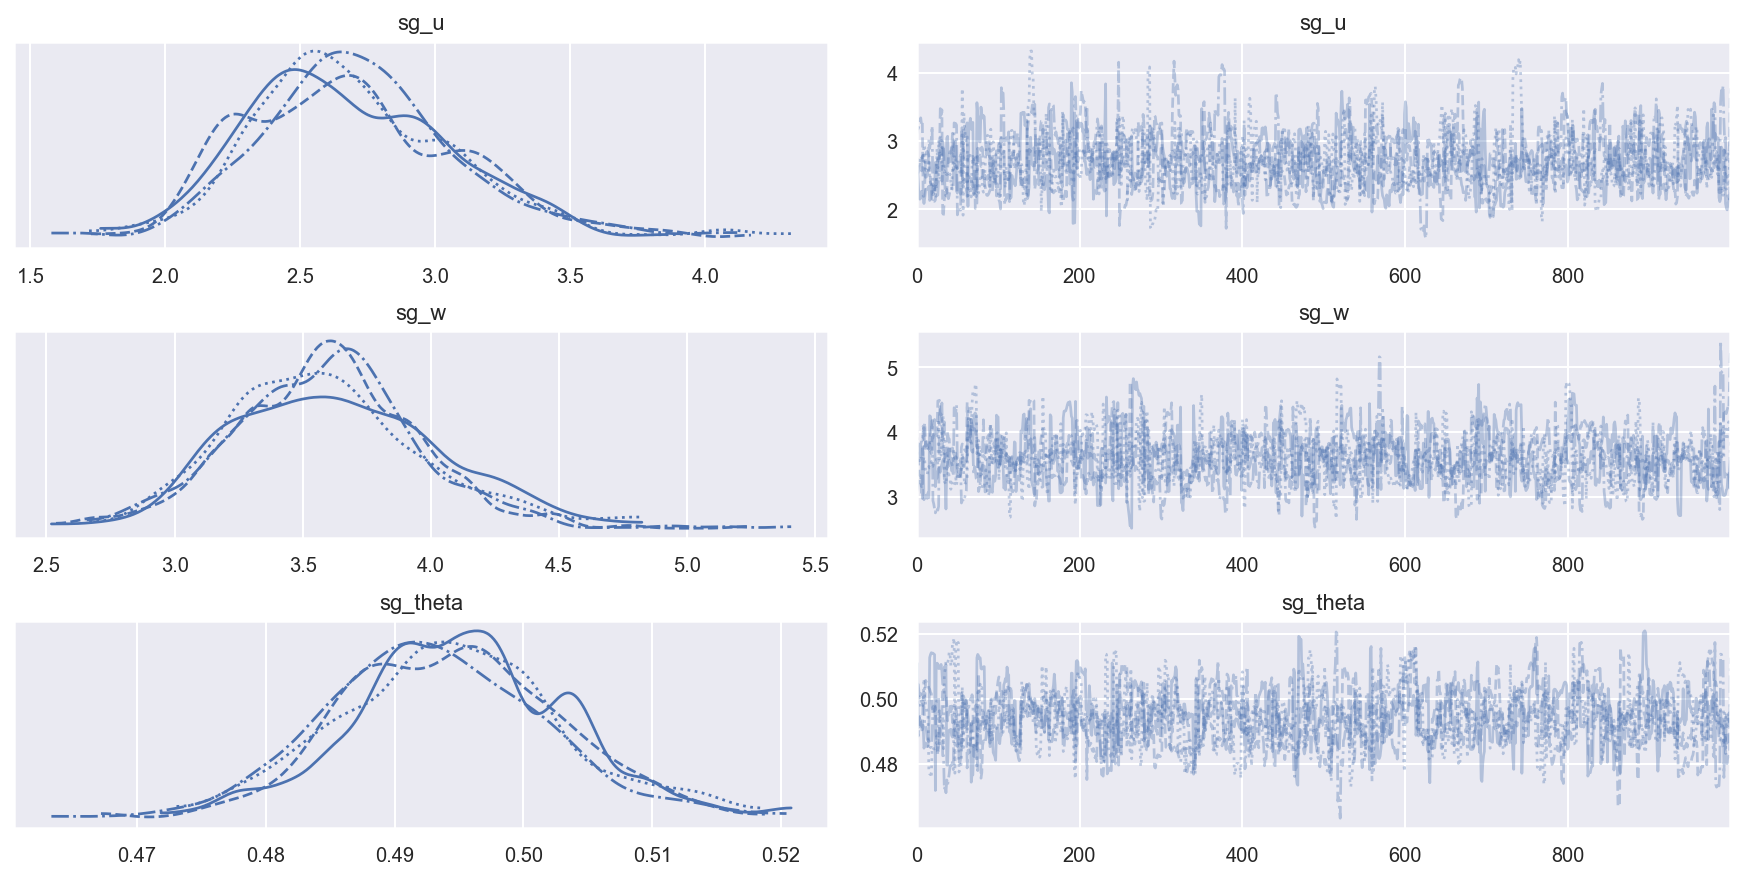

In [33]:
az.plot_trace(fit, var_names=["sg_u", "sg_w", "sg_theta"])

In [ ]:
a = np.random.normal(2, 3, size=10000)
b = np.random.normal(4, 5, size=10000)
c = a + b
print("mean", np.mean(c), "std", np.std(c), "var", np.std(c)**2)

In [ ]:
var = 3**2 + 5**2
std = np.sqrt(var)
print("var", var, "std", std)

## Memory model

In [ ]:
model = """
data {
    int<lower=1> U;  // Number of users    
    int<lower=1> A;  // Number of words
    int<lower=1> T; // Number of interactions
    int<lower=0, upper=U> user[T];
    int<lower=0, upper=A> word[T];
    vector[2] states[T];
    int<lower=0, upper=1> y[T];
}
parameters {
    vector[2] theta[A,U];
}
transformed parameters {
    real p[T]; 
    for (t in 1:T) 
        p[t] = exp(- theta[word[t],user[t]][1] * pow(1 - theta[word[t],user[t]][2], states[t][1]) * states[t][2]);
}
model {
    y ~ bernoulli(p);
}
"""
sm = pystan.StanModel(model_code=model)



mu_u = np.array([1.0, .5])
Sigma_u = .1 * np.eye(2)

mu_a = np.array([0, 0])
Sigma_a = .02 * np.eye(2)

Sigma_theta = .04 * np.eye(2)

A = 10
U = 15

L = np.random.multivariate_normal(mu_u, Sigma_u, U)
D = np.random.multivariate_normal(mu_a, Sigma_a, A)

theta = np.random.multivariate_normal(np.zeros(2), Sigma_theta, (A,U))

for a in range(A):
    for u in range(U):
        theta[a,u] = theta[a,u] + L[u] + D[a]
        

T = 150
word = np.random.randint(0, A, T)
user = np.random.randint(0, U, T)
last = np.random.randint(0, 10, T)
n_seen = np.random.randint(1, 5, T)
states = np.vstack((last, n_seen)).transpose()
beta = np.array([max(min(0, theta[word[t],user[t]][1]),1) for t in range(T)])
p = np.array([np.exp(- theta[word[t],user[t]][0] * np.power(1 - beta[t], states[t][0]) * states[t][1]) for t in range(T)])
y = np.random.binomial(n=1, p=p)




data = {'U': U, 'A': A, 'T':T, 'user':user, 'word':word, 'states':states, 'y':y, 'theta': theta}

# Compile the model
sm = pystan.StanModel(model_code=model)

In [ ]:
# Train the model and generate samples
fit = sm.sampling(data=data, iter=100, chains=4, warmup=50, thin=1, seed=101)
fit

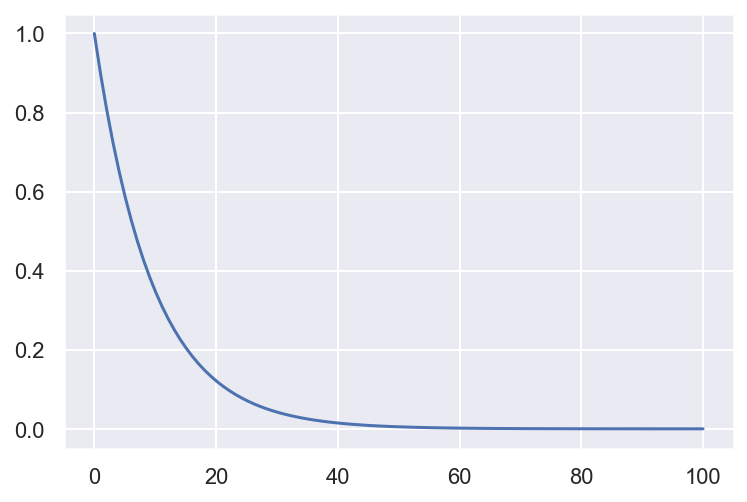

In [72]:
alpha= 1
beta=0.9

x = np.linspace(0, 100, 100)
y = alpha * beta**x

plt.plot(x, y)

In [ ]:
# # Put it to true if you edit the model
# force_compilation = True

# # Where to save backup
# bkp_folder = 'bkp'
# os.makedirs(bkp_folder, exist_ok=True)
# bkp_file = os.path.join(bkp_folder, 'model_regression.pkl')

# if not os.path.exists(bkp_file) or force_compilation is True:
    
#     # Compile the model
#     sm = pystan.StanModel(model_code=model)
    
#     # Save the model
#     with open(bkp_file, 'wb') as f:
#         pickle.dump(sm, f)
# else:
#     # Load the model
#     sm = pickle.load(open(bkp_file, 'rb'))